# Simple Simulation Code 
Code aims to roughly approximate the behavior of the goniometer nudges. In other words, this code does not use a realistic coherent edge simulation, but is focused on mimicking the behavior of nudges in the real data. This can be used as a first approximation, or to initially set up our RL workflow.  
## Limitations of the code include:
* No time delay between nudges and the coherent edge energy changing. This will be implemented in the sim_engine class 
* No wobble effect in the goniometer. This will be implemented in the goniometer class 
* No motor speed in goniometer, all changes instantaneous. This will be implemented in the goniometer class


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_sign(value):
    if value>0:
        return 1
    elif value<0:
        return -1
    else:
        return 0

# Class created to mimic the behavior of the goniometer
includes description of backlash. In principle, this could be used with a more realistic coherent edge sim from the beam spot finder to account for backlash. Still need to add:
* motor speed
* wobble effect 

In [ ]:
# goniometer doesn't know about the photon beam, but does know about backlash
# need separate function to change photon energy based on actual change in diamond angles after backlash

class goniometer:
    def __init__(self, run_period):

        # possible diamond orientations [should I include amorphous?] 
        self.orientations = ["0/90 PERP","0/90 PARA","45/135 PERP","45/135 PARA"]

        self.current_orientation = "Undefined"
        self.current_set_yaw = 0
        self.current_set_pitch = 0
        self.current_set_roll = 0
        self.current_set_x = 0
        self.current_set_y = 0

        self.current_rbv_yaw = 0
        self.current_rbv_pitch = 0
        self.current_rbv_roll = 0
        self.current_rbv_x = 0
        self.current_rbv_y = 0

        # backlash tracking, will be a number between -2.1 and 2.1 
        self.pitch_recent_moves = 0
        # backlash tracking, will be a number between -4.1 and 4.1 
        self.yaw_recent_moves = 0

        self.current_diamond_pitch = 0
        self.current_diamond_yaw = 0

        # 2.1 millidegrees of backlash in pitch
        self.backlash_pitch = 2.1/1000.0
        # around 4.1 millidegrees of backlash in yaw
        self.backlash_yaw = 4.1/1000.0

        # set rough initial goniometer values for each orientation 
        self.orientation_x = [0, 0, 0, 0]
        self.orientation_y = [0, 0, 0, 0]

        # based on data from each run period
        if run_period=="2020":
            self.orientation_pitch = [0.39,-0.73,0.39,1.81]
            self.orientation_yaw = [1.4,2.4,0.73,0.84]
            self.orientation_roll = [-10.5,-10.5,34.5,34.5]
        elif run_period=="2023":
            self.orientation_pitch = [-0.66,0.33,-1.75,-0.28]
            self.orientation_yaw = [0.17,1.28,0.96,1.06]
            self.orientation_roll = [162,162,-153,-153]
        elif run_period=="2025":
            self.orientation_pitch = [1.68,0.59,0.46,0.46]
            self.orientation_yaw = [1.52,1.94,1.94,0.49]
            self.orientation_roll = [-16.6, -16.6, 28.4, 28.4]
        else:
            print("Run period",run_period,"not currently set up")
            exit(0)
    

    # change orientation, track direction for backlash accounting (done in change_diamond_angles)
    def change_orientation(self, new_orientation):

        orientation_index = self.orientations.index(new_orientation)

        initial_pitch = self.current_set_pitch 
        initial_yaw = self.current_set_yaw 
        initial_roll = self.current_set_roll

        # set angle values change immediately (could add time delayed rbv)
        self.current_set_pitch = self.orientation_pitch[orientation_index]
        self.current_set_yaw = self.orientation_yaw[orientation_index]
        self.current_set_roll = self.orientation_roll[orientation_index]

        # size and sign of angle change in each direction
        nudge_pitch = self.current_set_pitch - initial_pitch 
        nudge_yaw = self.current_set_yaw - initial_yaw 
        nudge_roll = self.current_set_roll - initial_roll

        # change the diamond angles, accounting for backlash (no roll, not needed for energy changes)
        self.change_diamond_angles("pitch", nudge_pitch)
        self.change_diamond_angles("yaw",nudge_yaw)

        # tell the motors to start moving (modify readback values)
        self.start_your_engines("pitch",nudge_pitch)
        self.start_your_engines("yaw",nudge_yaw)
        self.start_your_engines("roll",nudge_roll)
        


    # here we eventually want the readback value to step in time, for now, just immediately set it to the right value since we don't know the motor speeds 
    def start_your_engines(self, motor, signed_nudge_size):

        if motor=="pitch":
            motor_speed = 0.001 # totally guess that it is 1 millidegree a second
            time_to_finish = abs(signed_nudge_size)/motor_speed
            self.current_rbv_pitch += signed_nudge_size
            # maybe change diamond angles here too?

        if motor=="yaw":
            motor_speed = 0.001
            time_to_finish = abs(signed_nudge_size)/motor_speed 
            self.current_rbv_yaw += signed_nudge_size 

        if motor=="roll":
            motor_speed = 0.01
            time_to_finish = abs(signed_nudge_size)/motor_speed 
            self.current_rbv_roll += signed_nudge_size 

        if motor=="x":
            motor_speed = 0.5 
            time_to_finish = abs(signed_nudge_size)/motor_speed 
            self.current_rbv_x += signed_nudge_size 
            
        if motor=="y":
            motor_speed = 0.5 
            time_to_finish = abs(signed_nudge_size)/motor_speed 
            self.current_rbv_y += signed_nudge_size


    # this is where we account for backlash
    def change_diamond_angles(self, motor, signed_nudge_size):

        if abs(signed_nudge_size)<0.0001:
            print("nudge of size less than a 1/10 millidegree given, ignoring")
            return

        if motor=="pitch":
                
            # nudge needs to be same sign as recent_moves and recent_moves needs to be +/- 2.1 for no backlash
            if get_sign(signed_nudge_size)*self.backlash_pitch!=self.pitch_recent_moves:
                # amount of backlash is bigger than the current nudge, so diamond angle won't change
                if abs(self.pitch_recent_moves+2.0*signed_nudge_size)<self.backlash_pitch:
                    # but progress is made towards clearing the backlash
                    self.pitch_recent_moves+=2.0*signed_nudge_size 
                else:
                    # have backlash that will be partially cancelled 
                    nudge_amount_cancelled = (self.backlash_pitch-abs(self.pitch_recent_moves))/2.0
                    actual_nudge_size_signed = signed_nudge_size-get_sign(signed_nudge_size)*nudge_amount_cancelled
                    self.current_diamond_pitch+=actual_nudge_size_signed
                    self.pitch_recent_moves = get_sign(actual_nudge_size_signed)*self.backlash_pitch
            else:
                # just change the diamond angle by the requested amount 
                self.pitch_recent_moves+=2.0*signed_nudge_size
                self.current_diamond_pitch+=signed_nudge_size
                if abs(self.pitch_recent_moves)>self.backlash_pitch:
                    # max size of recent moves should be max size of the backlash, but keep the correct sign
                    self.pitch_recent_moves = get_sign(self.pitch_recent_moves)*self.backlash_pitch
        
        elif motor == "yaw":
            if get_sign(signed_nudge_size)*self.backlash_yaw!=self.yaw_recent_moves:
                # amount of backlash is bigger than the current nudge, so diamond angle won't change
                if abs(self.yaw_recent_moves+2.0*signed_nudge_size)<self.backlash_yaw:
                    # but progress is made towards clearing the backlash
                    self.yaw_recent_moves+=2.0*signed_nudge_size 
                else:
                     # backlash should be cleared, but we will have a less effective nudge
                    nudge_amount_cancelled = (self.backlash_yaw-abs(self.yaw_recent_moves))/2.0
                    actual_nudge_size_signed = signed_nudge_size-get_sign(signed_nudge_size)*nudge_amount_cancelled
                    self.current_diamond_yaw+=actual_nudge_size_signed
                    self.yaw_recent_moves = get_sign(actual_nudge_size_signed)*self.backlash_yaw


            else:# no backlash
                self.yaw_recent_moves+=2.0*signed_nudge_size
                self.current_diamond_yaw+=signed_nudge_size

                if abs(self.yaw_recent_moves)>self.backlash_yaw:
                    self.yaw_recent_moves = get_sign(self.yaw_recent_moves)*self.backlash_yaw


    def do_nudge(self, motor, nudge_size_signed):
        if motor=="pitch":
            self.current_set_pitch += nudge_size_signed 
            self.change_diamond_angles(motor,nudge_size_signed)
            self.start_your_engines(motor,nudge_size_signed)

        elif motor=="yaw":
            self.current_set_yaw += nudge_size_signed
            self.change_diamond_angles(motor,nudge_size_signed)
            self.start_your_engines(motor,nudge_size_signed)


    def print_state(self):
        print("current set pitch is",self.current_set_pitch)
        print("current set yaw is",self.current_set_yaw)
        print("current set roll is",self.current_set_roll)

        print("current diamond pitch is",self.current_diamond_pitch)
        print("current diamond yaw is",self.current_diamond_yaw)

        print("current pitch recent moves is",self.pitch_recent_moves)
        print("current yaw recent moves is",self.yaw_recent_moves)


    def return_state(self):
        return {"pitch_set":self.current_set_pitch, "yaw_set":self.current_set_yaw,  "diamond_pitch":self.current_diamond_pitch, "diamond_yaw":self.current_diamond_yaw}
            
    def return_diamond_pitch(self):
        return self.current_diamond_pitch
    
    def return_diamond_yaw(self):
        return self.current_diamond_yaw
    
    def return_set_pitch(self):
        return self.current_set_pitch
    
    def return_set_yaw(self):
        return self.current_set_yaw
    
    def return_set_roll(self):
        return self.current_set_roll

        

   


# Testing of the Goniometer Object

In [4]:
def record_step(goni, times, pitches, rolls, yaws):
    if len(times)==0:
        times.append(1)
    else:
        times.append(times[-1]+1)
    pitches.append(goni.return_set_pitch())
    rolls.append(goni.return_set_roll())
    yaws.append(goni.return_set_roll())
    


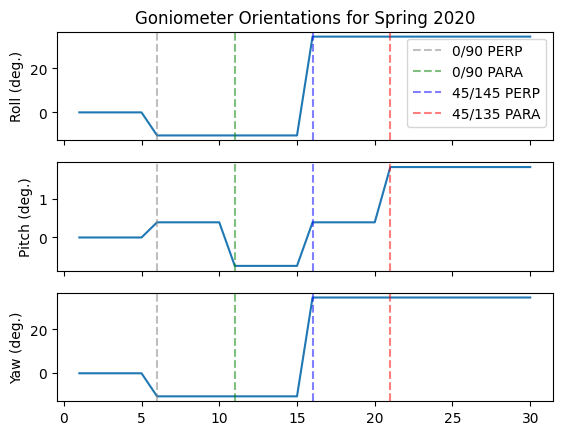

In [9]:
def show_goni_orientations(run_period):
    my_goni = goniometer(run_period)

    time_vals = []
    pitch_vals = []
    roll_vals = []
    yaw_vals = []

    for i in range(5):
        record_step(my_goni,time_vals,pitch_vals,roll_vals,yaw_vals)
    my_goni.change_orientation("0/90 PERP")
    for i in range(5):
        record_step(my_goni,time_vals,pitch_vals,roll_vals,yaw_vals)
    my_goni.change_orientation("0/90 PARA")
    for i in range(5):
        record_step(my_goni,time_vals,pitch_vals,roll_vals,yaw_vals)
    my_goni.change_orientation("45/135 PERP")
    for i in range(5):
        record_step(my_goni,time_vals,pitch_vals,roll_vals,yaw_vals)
    my_goni.change_orientation("45/135 PARA")
    for i in range(10):
        record_step(my_goni,time_vals,pitch_vals,roll_vals,yaw_vals)


    fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True)

    ax1.plot(time_vals,roll_vals)
    ax1.set_ylabel("Roll (deg.)")
    colors = ["gray","green","blue","red"]
    labels = ["0/90 PERP","0/90 PARA","45/145 PERP","45/135 PARA"]
    for i in range(4):
        ax1.axvline((i+1)*5+1,color=colors[i],alpha=0.5,linestyle='--',label=labels[i])
    ax1.legend()
    ax2.plot(time_vals,pitch_vals)
    for i in range(4):
        ax2.axvline((i+1)*5+1,color=colors[i],alpha=0.5,linestyle='--',)
    ax2.set_ylabel("Pitch (deg.)")
    ax3.plot(time_vals,yaw_vals)
    for i in range(4):
        ax3.axvline((i+1)*5+1,color=colors[i],alpha=0.5,linestyle='--')
    ax3.set_ylabel("Yaw (deg.)")

    ax1.set_title("Goniometer Orientations for Spring "+run_period)
    fig.savefig("plots/spring"+run_period+"_orientations.pdf")

show_goni_orientations("2020")

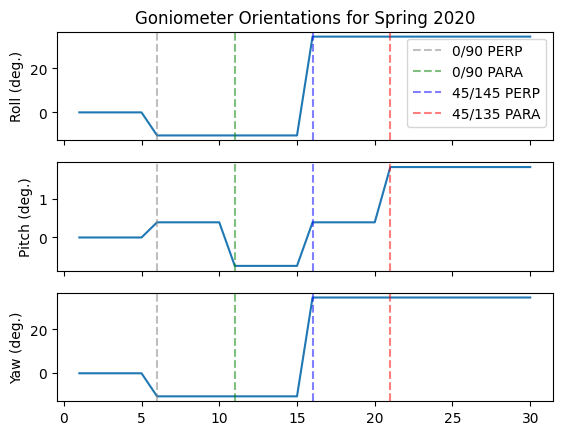

In [10]:
def test_goni(run_period, orientation):
    # plot set pitch, yaw, rbv, and diamond values to check backlash accounted for correctly 

    # change +10 millidegrees, -20 millidegrees, + 20 millidegrees all in 1 degree increments 

    pitch_values = []
    yaw_values = []
    diamond_pitch = []
    diamond_yaw = []

    my_goni = goniometer(run_period)
    # default orientation is all zero values
    my_goni.change_orientation(orientation)

    for i in range(10):
        my_goni.do_nudge("pitch",0.001)
        my_goni.do_nudge("yaw",0.001)

        current_state = my_goni.return_state()
        pitch_values.append(current_state['pitch_set'])
        yaw_values.append(current_state['yaw_set'])
        diamond_pitch.append(current_state['diamond_pitch'])
        diamond_yaw.append(current_state['diamond_yaw'])

    for i in range(20):
        my_goni.do_nudge("pitch",-0.001)
        my_goni.do_nudge("yaw",-0.001)

        current_state = my_goni.return_state()
        pitch_values.append(current_state['pitch_set'])
        yaw_values.append(current_state['yaw_set'])
        diamond_pitch.append(current_state['diamond_pitch'])
        diamond_yaw.append(current_state['diamond_yaw'])

    for i in range(20):
        my_goni.do_nudge("pitch",0.001)
        my_goni.do_nudge("yaw",0.001)

        current_state = my_goni.return_state()
        pitch_values.append(current_state['pitch_set'])
        yaw_values.append(current_state['yaw_set'])
        diamond_pitch.append(current_state['diamond_pitch'])
        diamond_yaw.append(current_state['diamond_yaw'])

    for i in range(20):
        my_goni.do_nudge("pitch",-0.001)
        my_goni.do_nudge("yaw",-0.001)

        current_state = my_goni.return_state()
        pitch_values.append(current_state['pitch_set'])
        yaw_values.append(current_state['yaw_set'])
        diamond_pitch.append(current_state['diamond_pitch'])
        diamond_yaw.append(current_state['diamond_yaw'])
    

    x_vals = [i for i in range(len(pitch_values))]


    fig, axes = plt.subplots(2,1, sharex=True)

    axes[0].plot(x_vals,pitch_values)
    axes[0].plot(x_vals,diamond_pitch)
    axes[0].set_xlabel("Step Number")
    axes[0].set_ylabel("Pitch Value")

    axes[1].plot(x_vals,yaw_values,label="Set Value")
    axes[1].plot(x_vals,diamond_yaw,label="Diamond Value")
    axes[1].set_ylabel("Yaw Value")
    axes[1].legend()

    fig.savefig("plots/goniometer_tests_"+run_period+".pdf")

show_goni_orientations("2020")

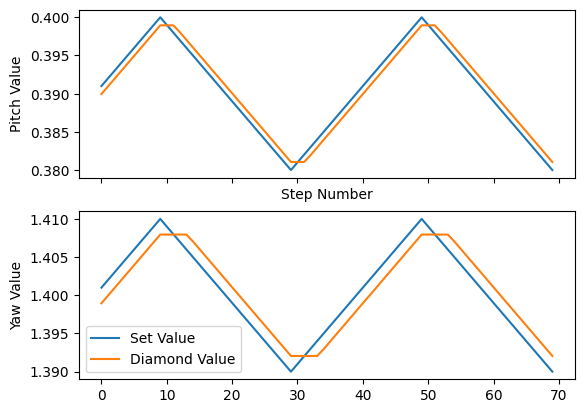

In [12]:
test_goni("2020","0/90 PERP")

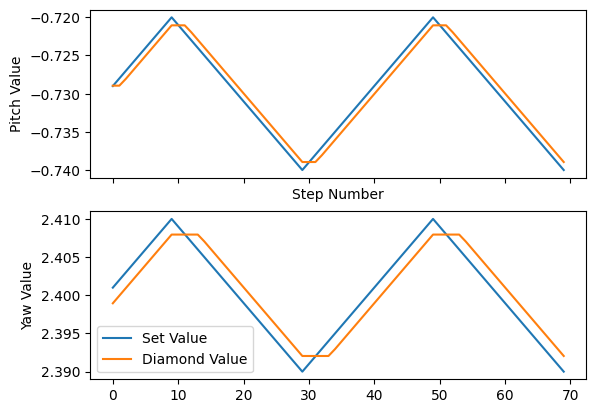

In [13]:
test_goni("2020","0/90 PARA")

In [14]:
def test_goni_straight(run_period,orientation):
    # plot set pitch, yaw, rbv, and diamond values to check backlash accounted for correctly 

    # change +10 millidegrees, -20 millidegrees, + 20 millidegrees all in 1 degree increments 

    pitch_values = []
    yaw_values = []
    diamond_pitch = []
    diamond_yaw = []

    my_goni = goniometer(run_period)
    # default orientation is all zero values
    my_goni.change_orientation(orientation)

    for i in range(100):
        my_goni.do_nudge("pitch",0.001)
        my_goni.do_nudge("yaw",0.001)

        current_state = my_goni.return_state()
        pitch_values.append(current_state['pitch_set'])
        yaw_values.append(current_state['yaw_set'])
        diamond_pitch.append(current_state['diamond_pitch'])
        diamond_yaw.append(current_state['diamond_yaw'])
    

    x_vals = [i for i in range(len(pitch_values))]


    fig, axes = plt.subplots(2,1, sharex=True)

    axes[0].plot(x_vals,pitch_values)
    axes[0].plot(x_vals,diamond_pitch)
    axes[0].set_xlabel("Step Number")
    axes[0].set_ylabel("Pitch Value")

    axes[1].plot(x_vals,yaw_values,label="Set Value")
    axes[1].plot(x_vals,diamond_yaw,label="Diamond Value")
    axes[1].set_ylabel("Yaw Value")
    axes[1].legend()

    

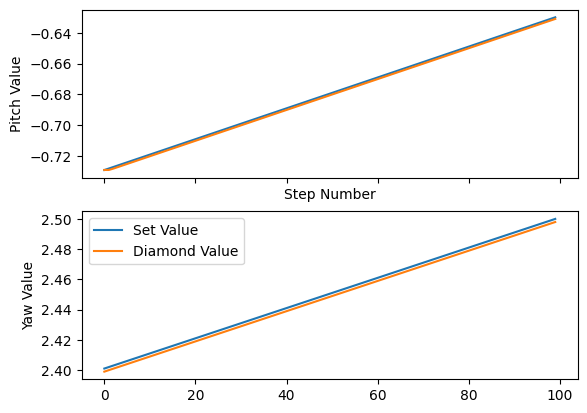

In [16]:
test_goni_straight("2020","0/90 PARA")

In [17]:
class state_vector:

    def __init__(self, max_length=20):

        self.var_list = ['ebeam:x','ebeam:y','ebeam:current','ebeam:energy','goni:pitch','goni:yaw','goni:roll','cbrem:plane','cbrem:energy','cbrem:energy_unc','ac:x','ac:y','yaw_diff','pitch_diff']
        self.max_length = max_length
        # store everything in a dict, since it is easy interpret and to pandify
        self.dict = {}
        for var in self.var_list:
            self.dict[var] = []

        self.length = 0

    def add_obs(self, input_data_dir):

        # should check input data right dim and not empty
        self.length+=1
        for var in self.var_list:
            if "diff" not in var:
                self.dict[var].append(input_data_dir[var])
                if self.length>self.max_length:
                    # if length over max_length, remove first element from list (deque better here?)
                    self.dict[var].pop(0)

    # track full motor history, and only when the direction actually changes
    def add_pitch_diff(self, pitch_diff):
        self.dict['pitch_diff'].append(pitch_diff)
        # only need last 5 or so entries, so 
        if len(self.dict['pitch_diff'])>self.max_length:
            self.dict['pitch_diff'].pop(0)
    
    def add_yaw_diff(self, yaw_diff):
        self.dict['yaw_diff'].append(yaw_diff)
        if len(self.dict['yaw_diff'])>self.max_length:
            self.dict['yaw_diff'].pop(0)




In [18]:
# returns signed number of nudges needed 
def adjust_peak(current_energy, goal_energy, nudge_size=10):
    # if we are more than 10 MeV from the goal energy, we should nudge
    if abs(current_energy-goal_energy)>10:
        # how many small nudges? diff in energy divided by 10 MeV rounded to the nearest int
        num_small_nudges = round((goal_energy-current_energy)/nudge_size,0)
        return num_small_nudges

    else:# do nothing if we are within 10 MeV
        return 0


In [19]:
def set_orientation_mode(gonio_obj, orientationMode):
    if orientationMode==1:
        gonio_obj.change_orientation("0/90 PERP")
    elif orientationMode==2:
        gonio_obj.change_orientation("0/90 PARA")
    elif orientationMode==3:
        gonio_obj.change_orientation("45/135 PERP")
    elif orientationMode==4:
        gonio_obj.change_orientation("45/135 PARA")
    else:
        print("orientationMode",orientationMode,"not defined")


# Simulation Engine

In [136]:
import matplotlib.ticker as ticker
# to start, just time series of energy as a Gaussian with 3 MeV noise
# nudge_times is list of times for each nudge 
# nudge_directions gives the sign of each nudge 
# orientation mode is 1 0/90 PERP, 2 0/90 PARA, 3 45/135 PERP, 4 45/135 PARA

class sim_engine:
    def __init__(self,run_period, orientation_mode):

        self.run_period = run_period
        self.orientation_mode = orientation_mode

        self.nudge_energy_size_pitch = 10.0
        self.nudge_energy_size_yaw = 10.0

        self.e_vals = []
        self.times = []
        self.pitch_vals = []
        self.yaw_vals = []
        self.diamond_pitch_vals = []
        self.diamond_yaw_vals = []

        self.nudge_times = []
        self.pitch_diffs = []
        self.yaw_diffs = []

        self.nudge_effectiveness = []

        self.energy_changes = []

        self.last_time = 0

        # default params for Al radiator
        
        self.plane_val = "Undefined"
        if orientation_mode in [2,4]: # can't do %2, because 0 is a good orientationMode for Al radiator
            self.plane_val = "PARA"
        else:
            self.plane_val = "PERP"

        self.roll_val = 0 # set roll to zero for Al by default
        self.ebeam_current = 300

        self.my_goni = goniometer(run_period)
        set_orientation_mode(self.my_goni,orientation_mode)

        self.ebeam_x = -0.5
        self.ebeam_y = 1.0

        # run period specific params
        if run_period=='2020':
            self.goal_energy = 8600
            self.cbrem_unc = 25
            self.ebeam_energy = 11377 # 3 MeV of noise?
            self.ac_x = 1.0
            self.ac_y = -0.2
            self.ebeam_current = 350 # same regardless of radiator

        elif run_period=="2023":
            self.goal_energy = 8620
            self.cbrem_unc = 18
            self.ebeam_energy = 11549
            self.ac_x = -0.5
            self.ac_y = 1.0
            self.ebeam_current = 300 # same regardless of radiator

        elif run_period=="2025":
            self.goal_energy = 8900
            self.cbrem_unc = 25
            self.ebeam_energy = 11688
            self.ac_x = 0.0
            self.ac_y = 0.15
            self.ebeam_current = 300 # for Al radiator

            if orientation_mode in [1,2,3,4]:
                self.ebeam_current = 200 # for any diamond radiator orientation 
        

    def get_data(self):
        return {"TimeStamp":self.times,"GONI:PITCH":self.pitch_vals,"GONI:YAW":self.yaw_vals,"CBREM:ENERGY":self.e_vals}
    



    def generate_flat_timestep(self, input_energy, noise_size):
        base_energy = input_energy 

        current_e = np.random.normal(base_energy,noise_size)

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 

        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        new_time = self.last_time+1 

        self.e_vals.append(current_e)
        self.times.append(new_time)
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time
        return base_energy
        


    # then, RL could hook into generate_timestep by telling it to nudge 
    def generate_nudge_timestep(self, input_energy, noise_size, nudge_direction, time_delay_on=True, next_nudge_time=100000):
        # angles will immediately update, but simulate with flat model for 5-10 seconds to mimic time delay of nudges

        base_energy = input_energy
        current_e = input_energy

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 

        new_time = self.last_time+1 

        base_step = 1.0/1000.0 # in degrees

                # size and direction of the change in energy
        if self.orientation_mode==1:
            nudge_energy = nudge_direction*self.nudge_energy_size_pitch
            step_size = abs(nudge_energy/self.nudge_energy_size_pitch*base_step)# in degrees


        prev_pitch = self.my_goni.return_set_pitch() 
        prev_yaw = self.my_goni.return_set_yaw()

        prev_diamond_pitch = self.my_goni.return_diamond_pitch()
        prev_diamond_yaw = self.my_goni.return_diamond_yaw()


        # this bit is a little messy, but here we keep track of the angle change that results in the energy change we want, which varies by run period

        # actually change pitch/yaw here. signs reverse for 0/90 PERP in Spring 23, for 45/135 PERP in Spring 25
        if self.orientation_mode==1:# 0/90 PERP
            if self.run_period!='2023':
                self.my_goni.do_nudge("pitch",-nudge_direction*step_size)# positive pitch change results in lower energy (at least for Spring 20)
            else:
                self.my_goni.do_nudge("pitch",nudge_direction*step_size) # positive pitch change results in higher energy (at least for Spring 20)

        if self.orientation_mode==2: # 0/90 PARA
            self.my_goni.do_nudge("yaw",-nudge_direction*step_size)

        if self.orientation_mode==3: # 45/135 PERP
            if self.run_period!='2025':
                self.my_goni.do_nudge("yaw",-nudge_direction*step_size/(2**0.5))
                self.my_goni.do_nudge("pitch",nudge_direction*step_size/(2**0.5))
            else:
                self.my_goni.do_nudge("yaw",nudge_direction*step_size/(2**0.5))
                self.my_goni.do_nudge("pitch",-nudge_direction*step_size/(2**0.5))
            
        if self.orientation_mode==4: # 45/135 PARA
            self.my_goni.do_nudge("yaw",-nudge_direction*step_size/(2**0.5))
            self.my_goni.do_nudge("pitch",-nudge_direction*step_size/(2**0.5))


        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw()
            
        yaw_diff = current_yaw-prev_yaw 
        pitch_diff = current_pitch-prev_pitch 
        

        current_effectiveness = ((current_diamond_pitch-prev_diamond_pitch)**2+(current_diamond_yaw-prev_diamond_yaw)**2)**0.5/0.001

        if current_effectiveness>1.5:# for big nudges
            current_effectiveness = current_effectiveness/10.0

        energy_change = nudge_direction*((current_diamond_pitch-prev_diamond_pitch)**2*self.nudge_energy_size_pitch**2+(current_diamond_yaw-prev_diamond_yaw)**2*self.nudge_energy_size_yaw**2)**0.5/0.001

        if time_delay_on:
            # then sim 8-10 seconds of flat energy before energy changes 
            num_secs = min(new_time+np.random.choice([8,9,10]),next_nudge_time)-new_time# need min of these to prevent skipping nudges when replicating actual runs
            print("num_secs is",num_secs)
            for k in range(num_secs):
                current_e = np.random.normal(input_energy,noise_size)

                if k==0:# time when the nudge occurred
                    self.yaw_diffs.append(yaw_diff)
                    self.pitch_diffs.append(pitch_diff)
                    self.nudge_times.append(new_time)
                    self.energy_changes.append(energy_change)
                    self.nudge_effectiveness.append(current_effectiveness)

                self.e_vals.append(current_e)
                self.times.append(new_time)
                self.pitch_vals.append(current_pitch)
                self.yaw_vals.append(current_yaw)

                self.diamond_pitch_vals.append(current_diamond_pitch)
                self.diamond_yaw_vals.append(current_diamond_yaw)
                new_time+=1


        base_energy += energy_change

        # include noise
        current_e = np.random.normal(base_energy,noise_size)



        #print("base_energy is",base_energy)
        self.e_vals.append(current_e)
        self.times.append(new_time)

        
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time

        return base_energy # new base energy is different, note current e is base + noise, base is the "true" energy



    def generate_linear_step(self, input_energy,noise_size,model_param=0):# param is just the slope
        base_energy = input_energy 
        new_time = self.last_time+1

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 
        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        base_energy+=model_param

        current_e = np.random.normal(base_energy,noise_size)

        self.e_vals.append(current_e)
        self.times.append(new_time)
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time 

        return base_energy


    # for sine model
    # model params will be normalization and period, maybe offset?
    #modified_base_energy=base_energy+model_params[0]*np.sin(i*2*np.pi/(model_params[1]))

    # everything done in generate_nudge_timestep, generate_flat_timestep, etc, just get right number of seconds here
    def generate_timeseries(self, num_seconds, input_energy, noise_size, energy_drift_model = 'None', model_params=[], auto_nudge = False):
        
        current_time = self.last_time 
        end_time = current_time+num_seconds
        current_energy = input_energy

        while current_time<end_time:

            if energy_drift_model=="None":
                current_energy = self.generate_flat_timestep(current_energy,noise_size)
            elif energy_drift_model=="linear":
                current_energy = self.generate_linear_step(current_energy,noise_size,model_params[0])
            elif energy_drift_model=="sine":
                print("not supported yet")
                return 
            elif energy_drift_model=="manual":
                # here we have a list of nudge times and directions
                nudge_times = model_params[0]
                nudge_directions = model_params[1]
                if current_time in nudge_times:
                    nudge_index = nudge_times.index(current_time)
                    next_nudge_time = 1000000
                    if len(nudge_times)-1>nudge_index:
                        next_nudge_time = nudge_times[nudge_index+1]

                    current_energy = self.generate_nudge_timestep(current_energy,noise_size,nudge_directions[nudge_index],True,next_nudge_time)
                else:
                    current_energy = self.generate_flat_timestep(current_energy,noise_size)

            # nudge step can be up to 11 seconds on its own
            current_time = self.last_time

    
            
        


    def plot_result(self,x_window=[],y_window=[20,20],title="",save_as=""):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(6,8),sharex=True)
        ax1.plot(self.times,self.e_vals)
        ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
        ax1.set_title(title)

        for time_index in range(len(self.nudge_times)):
            # draw vertical dashed line for each nudge 
            current_energy_change = self.energy_changes[time_index]
            if current_energy_change<0:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='red',alpha=0.5)
            elif current_energy_change>0:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='blue',alpha=0.5)
            else:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='gray',alpha=0.5)
    
        ax1.set_ylabel("$E_{\gamma}$ [MeV]")
        ax1.axhline(self.goal_energy,color='g')
        ax1.axhspan(self.goal_energy-10,self.goal_energy+10,color='g',alpha=0.1)
        ax1.set_ylim(self.goal_energy-y_window[0],self.goal_energy+y_window[1])

        ax2.plot(self.nudge_times,self.nudge_effectiveness,marker='o',color='black')
        ax2.set_ylabel("Nudge Effectiveness")
        ax2.axhline(1.0,color='black',alpha=0.2,linestyle='--')
        ax2.axhline(0.0,color='black',alpha=0.2,linestyle='--')

        ax3.plot(self.nudge_times,self.yaw_diffs,marker='o',label='YawDiff',color='blue')
        ax3.plot(self.nudge_times,self.pitch_diffs,marker='o',label='PitchDiff',color='orange')
        ax3.set_ylabel("Nudge Size (deg.)")
        ax3.legend()

        ax4.plot(self.times,self.pitch_vals,color='orange')
        ax4.set_ylabel('Pitch (deg.)')
        ax4.tick_params('y',colors='orange')

        ax4b = ax4.twinx()
        ax4b.plot(self.times,self.yaw_vals,color='blue')
        ax4.set_xlabel("Time (s)")
        ax4b.set_ylabel('Yaw (deg.)')
        ax4b.tick_params('y',colors='blue')

        #ax4.legend()





        if x_window!=[]:
            ax1.set_xlim(x_window[0],x_window[1])
            ax2.set_xlim(x_window[0],x_window[1])
            ax3.set_xlim(x_window[0],x_window[1])

        if save_as!="":
            plt.savefig(save_as)


num_secs is 10


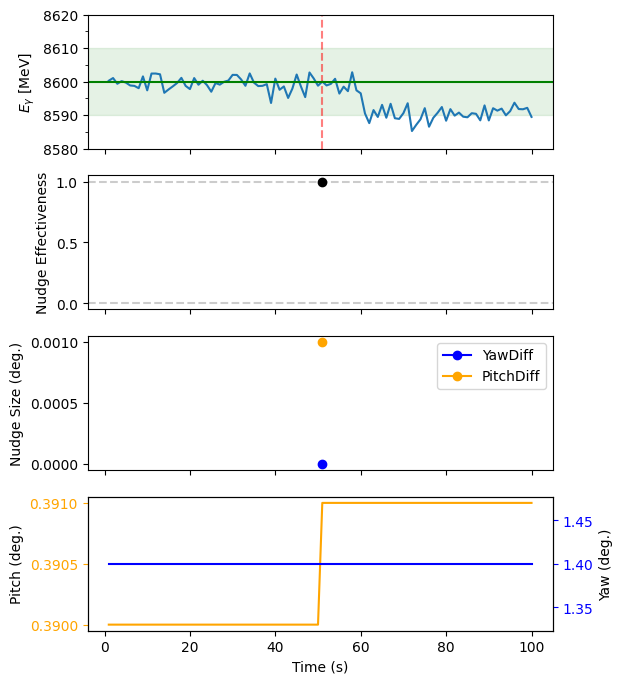

In [137]:
test_sim = sim_engine("2020",1)
test_sim.generate_timeseries(100,8600,2,"manual",[[50],[-1]])
test_sim.plot_result()

num_secs is 8
num_secs is 8
num_secs is 10
num_secs is 10
num_secs is 9
num_secs is 8
num_secs is 8
num_secs is 8
num_secs is 8
num_secs is 10


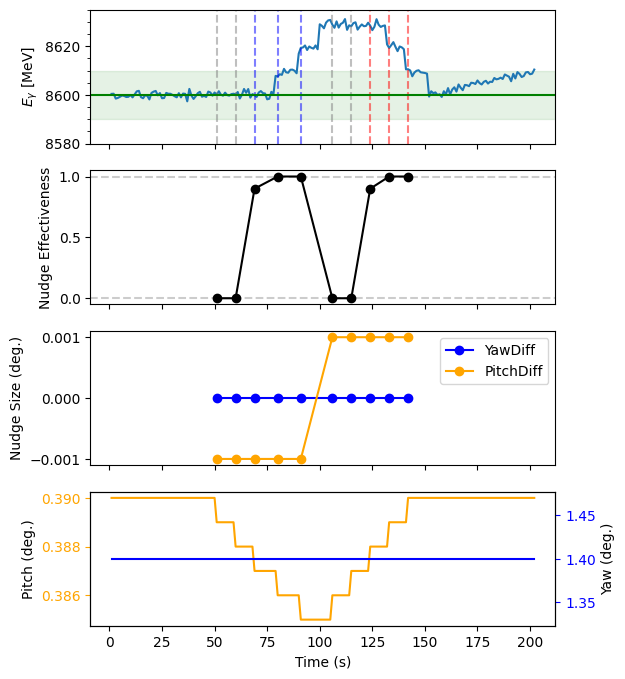

In [138]:
my_test = sim_engine("2020",1)
new_energy = 8600
for i in range(50):
    new_energy = my_test.generate_flat_timestep(new_energy,1)
for i in range(5):
    new_energy = my_test.generate_nudge_timestep(new_energy,1,1)
for i in range(5):
    new_energy = my_test.generate_flat_timestep(new_energy,1)
for i in range(5):
    new_energy = my_test.generate_nudge_timestep(new_energy,1,-1)
for i in range(50):
    new_energy = my_test.generate_linear_step(new_energy,1,0.2)
my_test.plot_result([],[20,35])


# Testing Sim functions

not supported yet


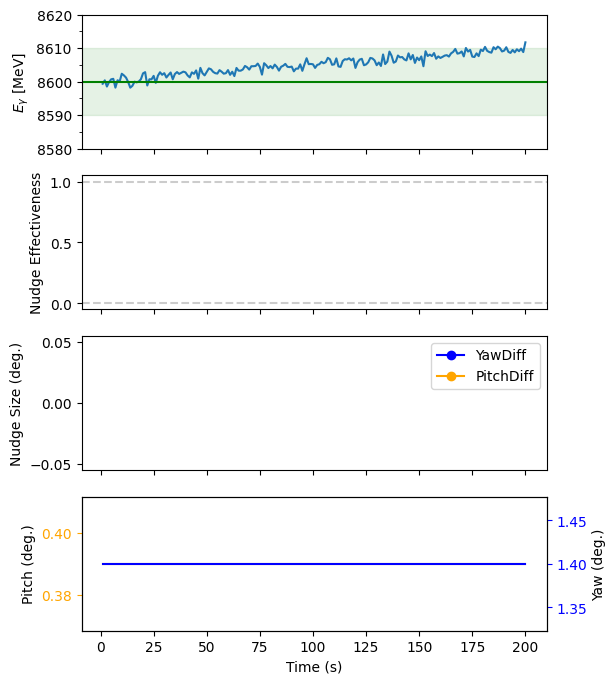

In [139]:
my_sim = sim_engine("2020",1)
my_sim.generate_timeseries(200,8600,1,"linear",[0.05])
my_sim.generate_timeseries(200,8600,1,"sine",[20,200])
my_sim.plot_result()

not supported yet


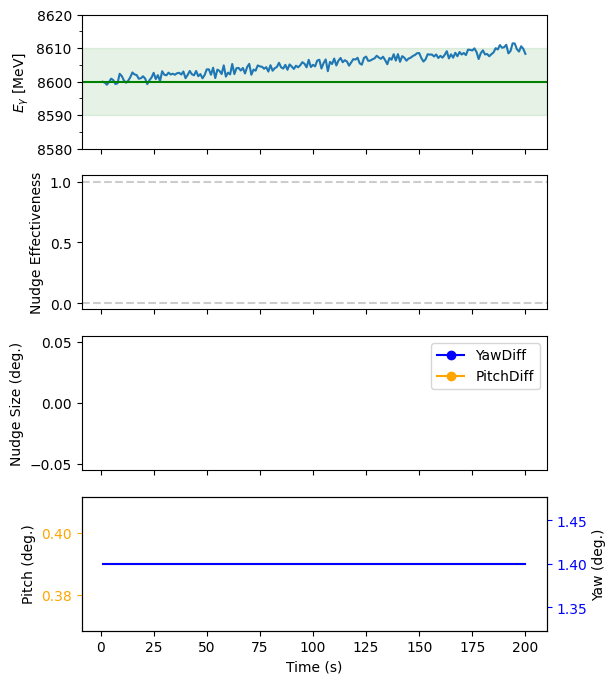

In [140]:
my_sim = sim_engine("2020",1)
my_sim.generate_timeseries(200,8600,1,"linear",[0.05])
my_sim.generate_timeseries(200,8600,1,"sine",[20,200],True)
my_sim.plot_result()

# Replicating actual runs

num_secs is 8
num_secs is 9
num_secs is 8
num_secs is 10
num_secs is 8


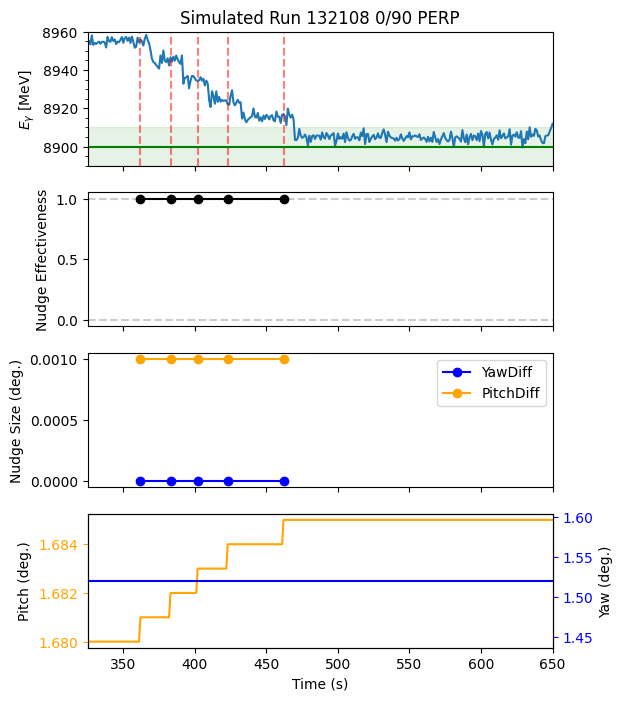

In [141]:
sim_132108 = sim_engine("2025",1)
sim_132108.generate_timeseries(650,8955,2,"manual",[[361,382,401,422,461],[-1,-1,-1,-1,-1]])
sim_132108.plot_result([325,650],[10,60],"Simulated Run 132108 0/90 PERP","plots/simulated_run_132108.pdf")

Replicating run 72105, a 0/90 PERP run from Spring 2020

num_secs is 8
num_secs is 9


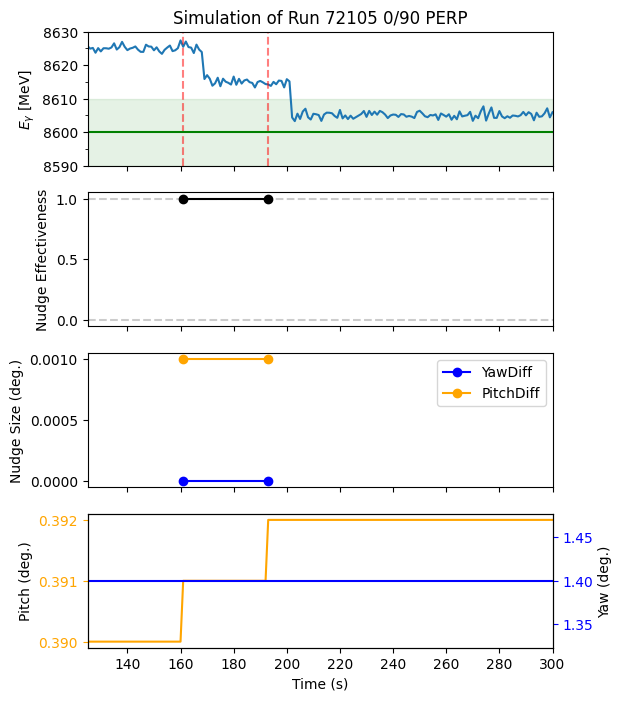

In [142]:
sim_72105 = sim_engine("2020",1)
sim_72105.generate_timeseries(300,8625,1,"manual",[[160,192],[-1,-1]])
sim_72105.plot_result([125,300],[10,30],"Simulation of Run 72105 0/90 PERP","plots/simulated_run_72105.pdf")
#generate_timeseries('2020',300,8625,1,1,'manual',[[160,192],[-10,-10]],[125,300],[10,30],"Simulation of Run 72105 0/90 PERP","plots/simulated_run_72105.pdf")

Replicating run 72127, a 0/90 PERP run from Spring 20 that has backlash

num_secs is 6
num_secs is 8
num_secs is 10
num_secs is 10
num_secs is 10


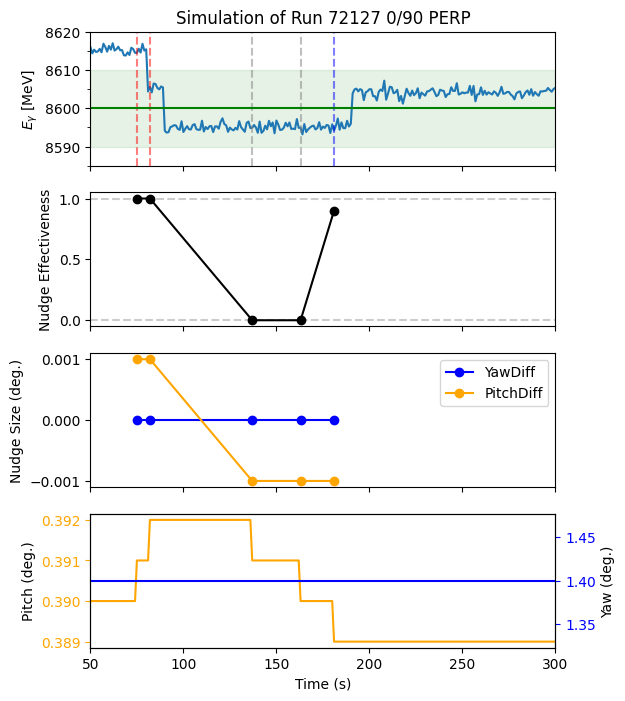

In [143]:
sim_72127 = sim_engine("2020",1)
sim_72127.generate_timeseries(300,8615,1,"manual",[[74,81,136,162,180],[-1,-1,1,1,1]])
sim_72127.plot_result([50,300],[15,20],"Simulation of Run 72127 0/90 PERP","plots/simulated_run_72127.pdf")

# Now testing Spring 2023 runs

nudge energy at time 246 is 10
energy change is 0.0
current_effectiveness is 0.0
diff in diamond yaw is  0.0
diff in diamond pitch is 0.0
nudge energy at time 373 is 10
energy change is 0.0
current_effectiveness is 0.0
diff in diamond yaw is  0.0
diff in diamond pitch is 0.0
nudge energy at time 388 is 10
energy change is 9.000000000000119
current_effectiveness is 0.9000000000000119
diff in diamond yaw is  0.0
diff in diamond pitch is 0.0009000000000000119
nudge energy at time 514 is -10
energy change is -0.0
current_effectiveness is 0.0
diff in diamond yaw is  0.0
diff in diamond pitch is 0.0
nudge energy at time 677 is -10
energy change is -0.0
current_effectiveness is 0.0
diff in diamond yaw is  0.0
diff in diamond pitch is 0.0


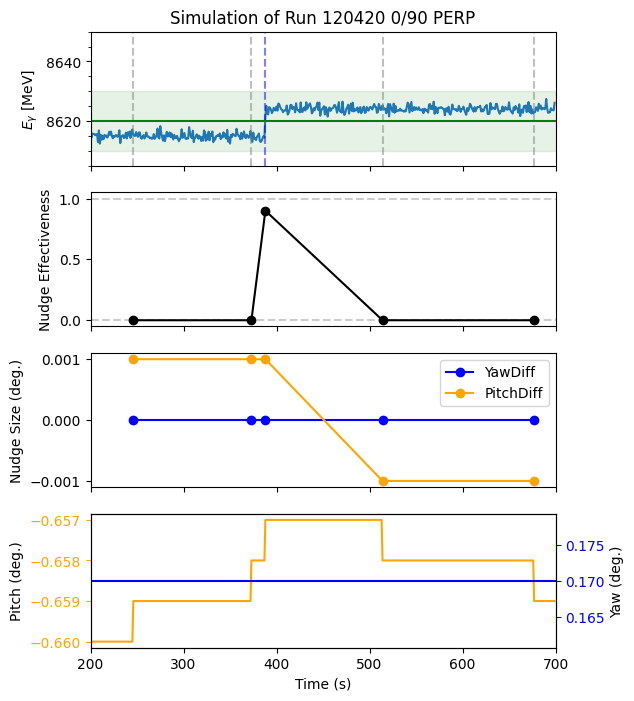

In [ ]:
sim_120420 = sim_engine("2023",1)
sim_120420.generate_timeseries(700,8615,1,"manual",[[246, 373, 388, 514, 677],[1,1,1,-1,-1]])
sim_120420.plot_result([200,700],[15,30],"Simulation of Run 120420 0/90 PERP","plots/simulated_run_120420.pdf")


# Now testing 2025

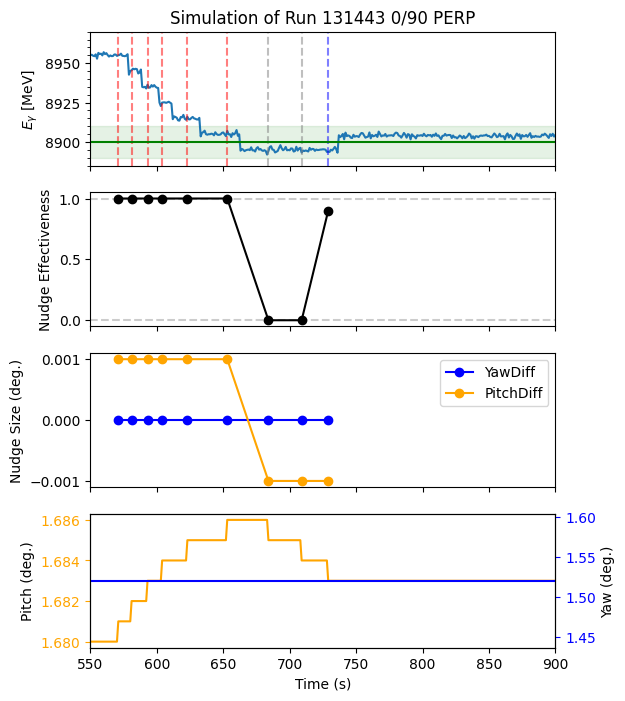

In [125]:
sim_131443 = sim_engine("2025",1)
sim_131443.generate_timeseries(900,8955,1,"manual",[[570,580,592,603,622,652,683,708,728],[-1,-1,-1,-1,-1,-1,1,1,1]])
sim_131443.plot_result([550,900],[15,70],"Simulation of Run 131443 0/90 PERP","plots/simulated_run_131443.pdf")

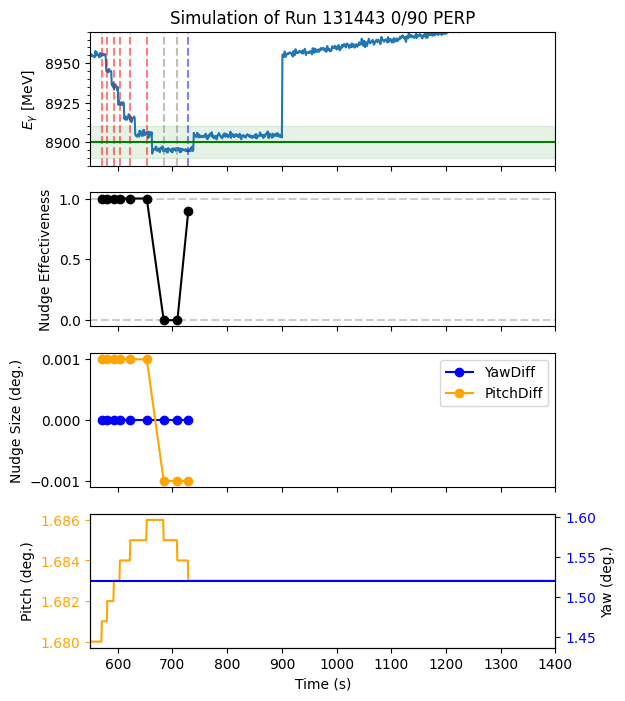

In [ ]:
# generate this run with a linear drift after the final nudge
sim_131443_hypothetical = sim_engine("2025",1)
sim_131443_hypothetical.generate_timeseries(900,8955,1,"manual",[[570,580,592,603,622,652,683,708,728],[-1,-1,-1,-1,-1,-1,1,1,1]])
sim_131443_hypothetical.generate_timeseries(500,8955,1,"linear",[0.05])
sim_131443_hypothetical.plot_result([550,1400],[15,70],"Simulation of Run 131443 0/90 PERP","plots/simulated_run_131443.pdf")

In [127]:
my_df = pd.DataFrame(sim_131443_hypothetical.get_data())
print(my_df.head())

   TimeStamp  GONI:PITCH  GONI:YAW  CBREM:ENERGY
0          1        1.68      1.52   8955.668344
1          2        1.68      1.52   8955.775090
2          3        1.68      1.52   8954.973940
3          4        1.68      1.52   8954.206026
4          5        1.68      1.52   8956.459938


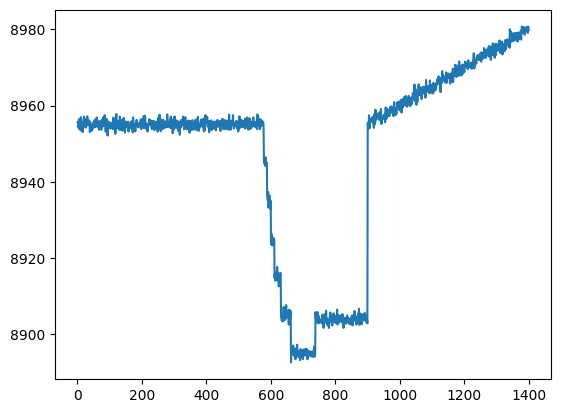

In [128]:
plt.plot(my_df['TimeStamp'],my_df['CBREM:ENERGY'])

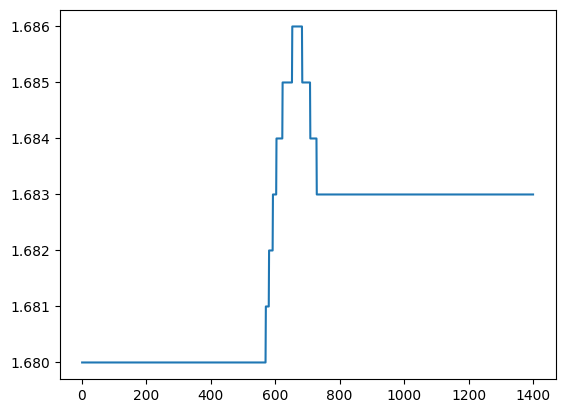

In [129]:
plt.plot(my_df['TimeStamp'],my_df['GONI:PITCH'])